In [17]:
import numpy as np
from collections import Counter
import copy
import pandas as pd
from sklearn.model_selection import train_test_split

In [26]:
class DTreeClassifierFromScratch:
    def __init__(self, max_depth):
        self.max_depth = max_depth     # Predetermined constant value
        self.u_class = None            # Target value class (y)
        self.estimator1 = dict()       # Tree result 1. Contains the data point ids (Detailed result)
        self.estimator2 = dict()       # Tree result 2. Contains the majority class (Summarized result)
        # Dict will lool like this:
        # {'feature_id': ..., 
        # 'split_point': ..., 
        # IF left AND right ARE LEAVES = 'left': value, 'right': value} 
        # IF NOT = 'left': {'feature_id': ..., 'split_point': ..., 'left': value, 'right': value}
        # }
        self.feature = None            # Will be x_train when fit() function is called
        self.target = None             # Will be y_train when fit() function is called
           
    # Function to calculate gini index for a leaf node
    # I will use gini index instead of entropy because it's the most popular one
    def gini_index(self, leaf):
        n = leaf.shape[0]
        gini = 1.0 # 1.0 is the highest value of gini index for multi class classification
        for c in self.u_class:
            # Calculate the number of data pounts whoose target is 0
            cnt = (self.target[leaf] == c).sum()
            # Calculate the ratio in which the number of target class is 0, and square it
            gini -= (cnt / n) ** 2
        return gini

    # Split a node into left and right
    # Find the best split point with highest Information Gain (IG) and split node with it
    def node_split(self, did):
        n = did.shape[0]
        
        # This is the gini index of parent node before splitting
        p_gini = self.gini_index(did)
        
        # Split the node into all candidates for all features
        # Find the best feature and the best split point with the highest IG
        max_ig  = -float("inf") # Set IG as very small value to find the maximum value of IG later
        for fid in range(self.feature.shape[1]):
            # Feature data to be split
            x_feat = self.feature[did, fid].copy()
            
            # Split x_feature using the best feature and the best split point
            # NOTE: The code below is inefficient because it sorts x_feature every time it is split
            # Remove duplicates of x_features and sort in ascending order
            x_uniq = np.unique(x_feat)
            
            # List up all the candidates, which are the midpoints of adjacent data
            s_point = [np.mean([x_uniq[i-1], x_uniq[i]]) for i in range(1, len(x_uniq))]
            
            # len(split_point_candidates) > 1:
            #     Calculate the IG for all candidates, and find the candidate with the largest IG
            # len(split_point_candidates) < 1:
            #     Skip the for-loop
            #     x_features either has only one data or all have the same value. No need for split
            for p in s_point:
                left = did[np.where(x_feat <= p)[0]]
                right = did[np.where(x_feat > p)[0]]
                               
                # Calculate Gini Index after splitting
                l_gini = self.gini_index(left)
                r_gini = self.gini_index(right)
                
                # Calculate IG
                ig = p_gini - (l_gini * left.shape[0] / n) - (r_gini * right.shape[0] / n)

                # Find where the IG is greatest
                if ig > max_ig:
                    max_ig = ig
                    b_fid = fid      # Best feature id
                    b_point = p      # Best split point
                    b_left = left    # Data index on the left node
                    b_right = right  # Data index on the right node
        
        if max_ig > 0.:     # Split
            return {'fid':b_fid, 'split_point':b_point, 'left':b_left, 'right':b_right}
        else:
            return  None    # No split

    # Create a binary tree using recursion
    def recursive_split(self, node, curr_depth):
        left = node['left']
        right = node['right']

        # Base case
        if curr_depth >= self.max_depth:
            return

        # Recursion
        s = self.node_split(left)
        if isinstance(s, dict):
            node['left'] = s
            self.recursive_split(node['left'], curr_depth+1)

        s = self.node_split(right)
        if isinstance(s, dict):
            node['right'] = s
            self.recursive_split(node['right'], curr_depth+1)
           
    # Majority class vote
    def majority_vote(self, did):
        c = Counter(self.target[did])
        return c.most_common(1)[0][0]
    
    # Change the data in the leaf node to majority class
    def update_leaf(self, d):
        if isinstance(d, dict):
            for key, value in d.items():
                if key == 'left' or key == 'right':
                    rtn = self.update_leaf(value) # Recursion
                    if rtn[0] == 1:
                        d[key] = rtn[1]
            # The 1st 0 means this is not a leaf node
            return 0, 0
        else:
            # The 1st 1 means this is a leaf node
            return 1, self.majority_vote(d)
    
    # Create a tree using training data and return the result of the tree
    def fit(self, x, y):
        self.feature = x
        self.target = y
        self.u_class = np.unique(y)
        
        # At the start the root node holds all data indicies
        root = self.node_split(np.arange(x.shape[0]))
        if isinstance(root, dict):
            self.recursive_split(root, curr_depth=1)
        
        # Tree result-1. Every leaf node has data indicies
        # It is used for predict_proba(), etc
        self.estimator1 = root
        
        # Tree result-2. Every leaf node has a majority class
        # It is used for predict()
        self.estimator2 = copy.deepcopy(self.estimator1)
        self.update_leaf(self.estimator2) # Tree result-2
        return self.estimator2

    # Estimate the target class of a test data.
    def x_predict(self, p, x):
        if x[p['fid']] <= p['split_point']:
            if isinstance(p['left'], dict):           # Recursion if not a leaf
                return self.x_predict(p['left'], x)
            else:                                     # Return the value in the leaf, if leaf
                return p['left']
        else:
            if isinstance(p['right'], dict):          # Recursion if not a leaf
                return self.x_predict(p['right'], x)
            else:                                     # Return the value in the leaf, if leaf
                return p['right']

    # Estimate the target class of a x_test
    def predict(self, x_test):
        p = self.estimator2 # Predictor
        y_pred = [self.x_predict(p, x) for x in x_test]
        return np.array(y_pred)

In [27]:
# Read the Titanic dataset and perform simple preprocessing
df = pd.read_csv('../data/Titanic-Dataset.csv')
df['Age'].fillna(df['Age'].mean(), inplace = True)  # Replace with average
df['Embarked'].fillna('N', inplace = True)          # Replace with 'N'
df['Sex'] = df['Sex'].factorize()[0]                # Label encoding
df['Embarked'] = df['Embarked'].factorize()[0]      # Label encoding
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.000000,1,0,7.2500,0
1,1,1,1,38.000000,1,0,71.2833,1
2,1,3,1,26.000000,0,0,7.9250,0
3,1,1,1,35.000000,1,0,53.1000,0
4,0,3,0,35.000000,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,0
887,1,1,1,19.000000,0,0,30.0000,0
888,0,3,1,29.699118,1,2,23.4500,0
889,1,1,0,26.000000,0,0,30.0000,1


In [28]:
# Split the data into train and test sets
y = np.array(df['Survived'])
x = np.array(df.drop('Survived', axis=1))
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [30]:
depth = 3
my_model = DTreeClassifierFromScratch(max_depth = depth)
my_model.fit(x_train, y_train)
my_pred = my_model.predict(x_test)
acc = (y_test == my_pred).mean()
print(f'MyTreeClassifier: accuracy = {acc}')

MyTreeClassifier: accuracy = 0.8026905829596412


DecisionTreeClassifier: accuracy = 0.8026905829596412

DTreeClassifierFromScratch: estimator2:
{'fid': 1,
 'split_point': 0.5,
 'left': {'fid': 0,
          'split_point': 1.5,
          'left': {'fid': 5, 'split_point': 26.14375, 'left': 0, 'right': 0},
          'right': {'fid': 2, 'split_point': 9.5, 'left': 1, 'right': 0}},
 'right': {'fid': 0,
           'split_point': 2.5,
           'left': {'fid': 5, 'split_point': 28.85625, 'left': 1, 'right': 1},
           'right': {'fid': 6, 'split_point': 0.5, 'left': 0, 'right': 1}}}


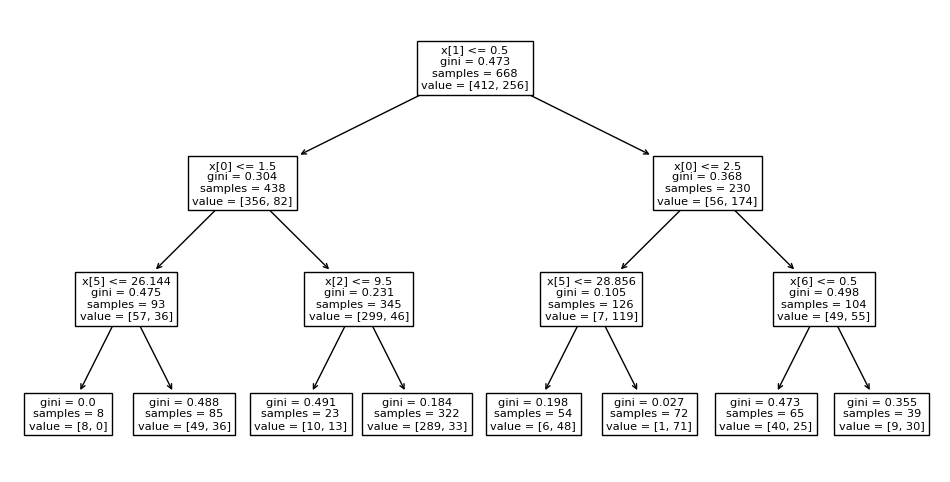

In [35]:
# Compare the results with sklearn's DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree
import pprint
sk_model = DecisionTreeClassifier(max_depth=depth, random_state=1)
sk_model.fit(x_train, y_train)
sk_pred = sk_model.predict(x_test)
acc = (y_test == sk_pred).mean()
print(f'DecisionTreeClassifier: accuracy = {acc}')

print('\nDTreeClassifierFromScratch: estimator2:')
pprint.pprint(my_model.estimator2, sort_dicts=False)

plt.figure(figsize=(12, 6))
tree.plot_tree(sk_model)
plt.show()